# Tutorial: Solving CommonRoad Planning Problems
This tutorial demonstrates how we can use the (un)informed search algorithms, combined with motion primitives, to solve real planning problems introduced in CommonRoad [scenarios](https://commonroad.in.tum.de/scenarios). 

## 0. Preparation
Before you proceed with this tutorial, make sure that

* you have gone through the tutorials on **CommonRoad Input-Output** and **(Un)Informed Search Algorithms**.
* you have installed all necessary modules for CommonRoad Search according to the installation manual.

Let's start with importing relevant modules and classes for setting up the automaton and the CommonRoad (CR) scenario.

In [14]:
%matplotlib inline

# enabling autoreload will reload modules automatically before executing the code, so that
# you can edit the code for your motion planners and execute them right away without reloading
%load_ext autoreload
%autoreload 2

import os
import sys
path_notebook = os.getcwd()

# add the root folder to python path
sys.path.append(os.path.join(path_notebook, "../../"))

import matplotlib.pyplot as plt
from IPython.display import clear_output

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

from SMP.motion_planner.motion_planner import MotionPlanner, MotionPlannerType
from SMP.maneuver_automaton.maneuver_automaton import ManeuverAutomaton
from SMP.motion_planner.utility import plot_primitives

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, we specify the motion planner that we want to use:

In [15]:
# uncomment the following lines to use different motion planners

# type_motion_planner = MotionPlannerType.UCS
# type_motion_planner = MotionPlannerType.GBFS
type_motion_planner = MotionPlannerType.ASTAR
# type_motion_planner = MotionPlannerType.STUDENT_EXAMPLE

# your own motion planner can be called by uncommenting next line
# type_motion_planner = MotionPlannerType.STUDENT

## 1. Loading CR Scenario and Planning Problem Set
In the next step, we load CommonRoad scenarios and their planning problems. Scenario ids beginning with prefix **"C-"** stand for cooeprative driving scenarios and possess multiple planning problems. The meaning of the symbols in a scenario are explained as follows:
* **Dot**: initial state projected onto the position domain
* **Red rectangle**: static obstacle
* **Blue rectangle**: dynamic obstacle
* **Yellow rectangle**: goal region projected onto the position domain

In [16]:
# load scenario
path_scenario = os.path.join(path_notebook, "../../scenarios/exercise/")
id_scenario = 'USA_Lanker-1_2_T-1'

# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

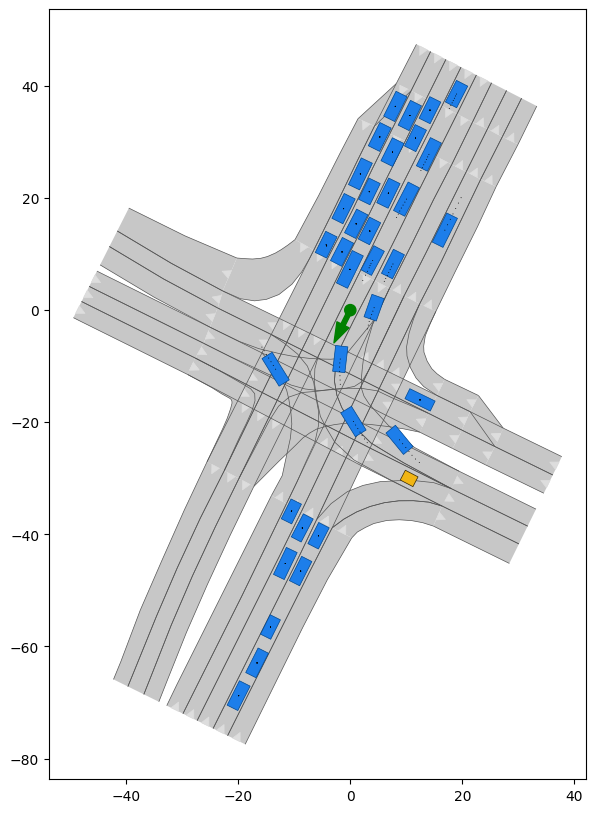

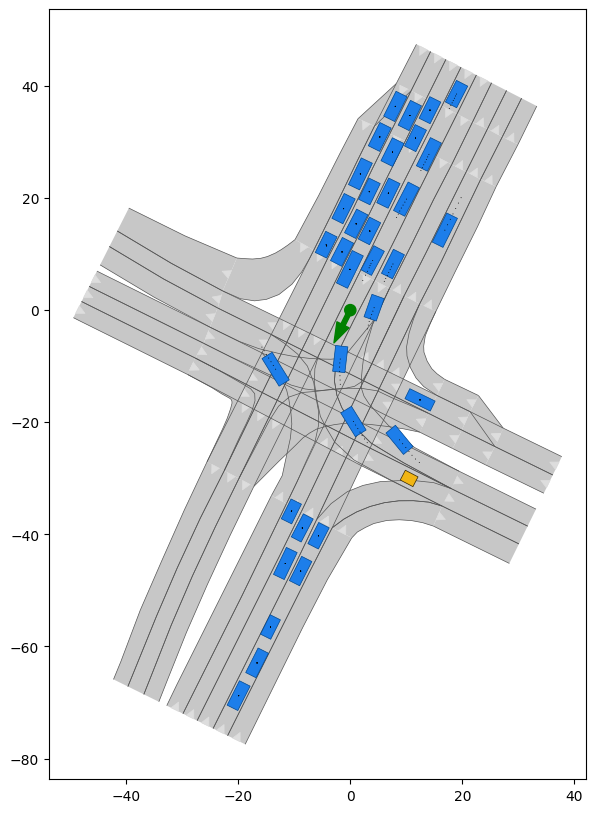

In [17]:
# plot the scenario for each time step
for i in range(0, 50):
    plt.figure(figsize=(10, 10))
    renderer = MPRenderer()
    
    # uncomment the following line to visualize with animation
    clear_output(wait=True)
    
    # plot the scenario for each time step
    scenario.draw(renderer, draw_params={'time_begin': i})
    
    # plot the planning problem set
    planning_problem_set.draw(renderer)
    
    renderer.render()
    plt.show()

## 2. Generating a Maneuver Automaton

In the following, we load the pre-generated motion primitives from an XML-File, and generate a **Maneuver Automaton** out of them. The primitives used here 
* The motion primitives are generated for the *Kinematic Single Track Model* (see [Vehicle Model Documentation](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf)) with parameters taken from vehicle model *BMW320i* (id_type_vehicle=2). 
* The motion primitives have a duration of 0.5 seconds, time step size of 0.1 seconds, and consists of 6 states. We assume constant input during this period. They have different velocities (ranging from 0 m/s to 20 m/s with step size of 4 m/s) and steering angles (ranging from -1.066 rad to 1.066 rad with a step size rounded to 0.18 rad) in their initial/final states, and resulting in a total of 167 distinct primitives.
* Two motion primitives are considered connectable if the velocity and the steering angle of the final state of the preceding primitive are equal to those of the initial state of the following primitive.
* By setting different ranges and steps for velocity and steering angle, one can obtain different sets of motion primitives: more primitives brings a higher coverage of state space when performing the search, but yields a higher branching factor and time of search; search with less primitives are usually faster, but chances are that no feasible trajectory leading to the goal region can be constructed with the set of primitives.

We create two automata with 524 and 167 feasible motion primitives, respectively.

Reading motion primitives from file V_0.0_20.0_Vstep_2.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml
Reading motion primitives from file V_0.0_20.0_Vstep_2.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml


  0%|          | 0/685 [00:00<?, ?it/s]

  0%|          | 0/685 [00:00<?, ?it/s]

Automaton created.
Number of loaded primitives: 524
Automaton created.
Number of loaded primitives: 524


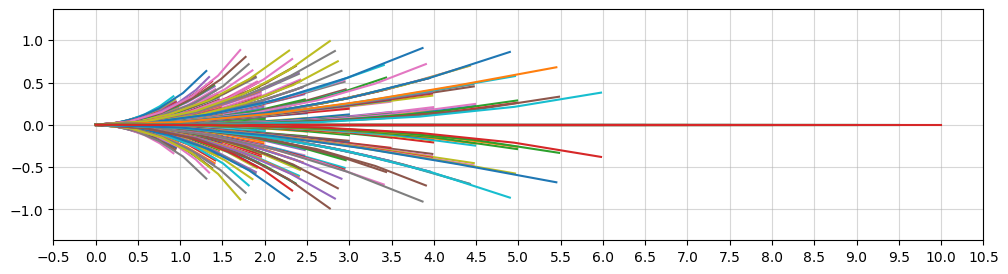

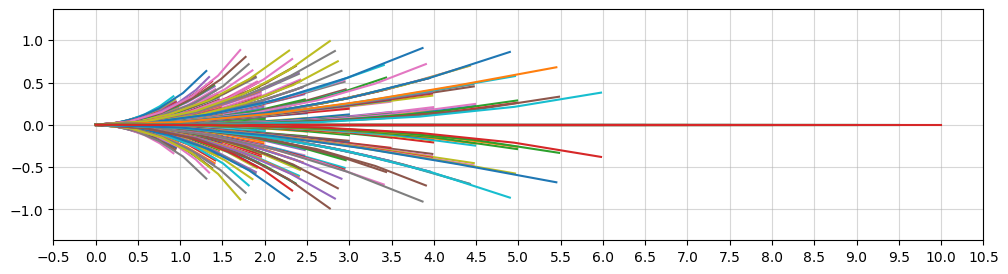

In [18]:
# load the xml with stores the motion primitives
name_file_motion_primitives = 'V_0.0_20.0_Vstep_2.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml'
# generate automaton
automaton = ManeuverAutomaton.generate_automaton(name_file_motion_primitives)
# plot motion primitives
plot_primitives(automaton.list_primitives)

Reading motion primitives from file V_0.0_20.0_Vstep_4.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml
Reading motion primitives from file V_0.0_20.0_Vstep_4.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

Automaton created.
Number of loaded primitives: 167
Automaton created.
Number of loaded primitives: 167


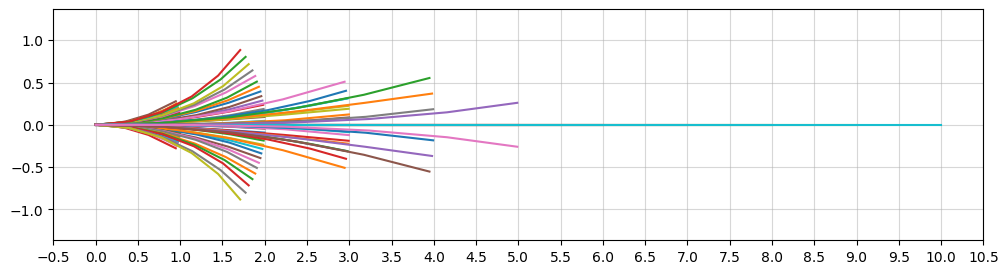

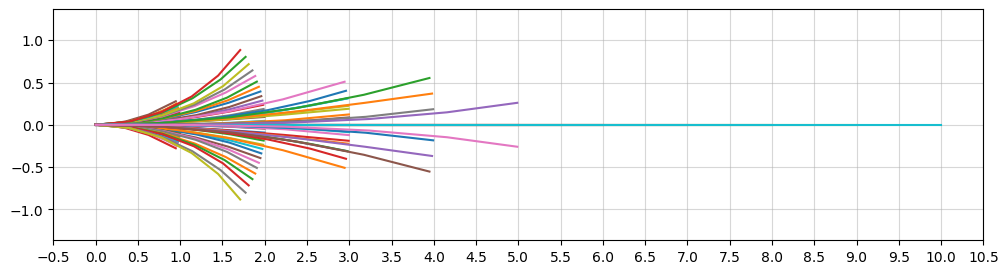

In [19]:
# load the xml with stores the motion primitives
name_file_motion_primitives = 'V_0.0_20.0_Vstep_4.0_SA_-1.066_1.066_SAstep_0.18_T_0.5_Model_BMW_320i.xml'
# generate automaton
automaton = ManeuverAutomaton.generate_automaton(name_file_motion_primitives)
# plot motion primitives
plot_primitives(automaton.list_primitives)

If necessary, you can also create your own set of motion primitives (refer to **tutorial_motion_primitive_generator.ipynb**)

## 3. Searching for solutions
We now carry out the search for solutions with the automaton of 167 primitives.

### 3.1 Initializing motion planner

In this step, we would like to create a motion planner with the loaded scenario, planning problem, and the automaton.

In [20]:
# construct motion planner
motion_planner = MotionPlanner.create(scenario=scenario, 
                                      planning_problem=planning_problem,
                                      automaton=automaton, 
                                      motion_planner_type=type_motion_planner)

### 3.2 Executing the search
Search for the solution can be executed by calling the `execute_search` function of the motion planner.

In [21]:
# solve for solution
list_paths_primitives, _, _ = motion_planner.execute_search()

### 3.3 Creating Trajectory object from the planning result
The solutions returned by the motion planner is a list of List[State], which stores the states of the motion primitives constructing the solution trajectory. Note that the final state of a predecessor primitive is the same as the initial state of a successor primitive, thus we have to remove the duplicates in states.

In [22]:
from commonroad.scenario.trajectory import State, Trajectory
from SMP.motion_planner.utility import create_trajectory_from_list_states

trajectory_solution = create_trajectory_from_list_states(list_paths_primitives)

### 3.4 Visualizing planned trajectory
Given that we have constructed a feasible trajectory, we now visualize our solution (ego vehicle shown with green rectangle):

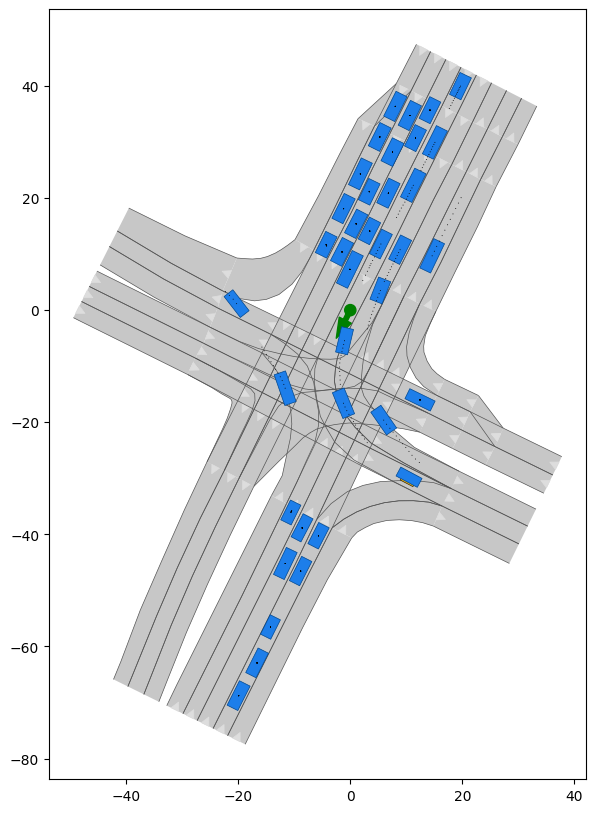

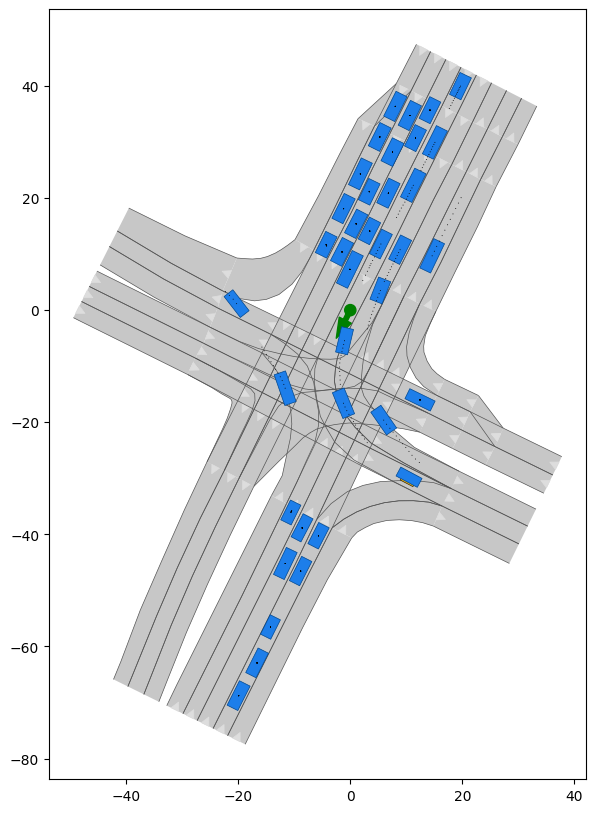

In [23]:
from SMP.motion_planner.utility import visualize_solution
visualize_solution(scenario, planning_problem_set, trajectory_solution)

## 4. Checking Validity of Planning Results
We provide a [Drivability Checker](https://commonroad.in.tum.de/drivability_checker) to verify the validity of the planned trajectories in terms of collision avoidance, kinematic feasibility, reaching goal state, etc. Here we demonstrate how to verify your solutions before saving and uploading them to the CommonRoad server. More information can be found at [Solution Checker](https://commonroad.in.tum.de/docs/commonroad-drivability-checker/sphinx/api_feasibility.html?highlight=valid_solution#module-commonroad_dc.feasibility.solution_checker).

### 4.1 Creating Solution object
Documentation regarding the **Solution** object can be found [here](https://commonroad-io.readthedocs.io/en/latest/api/common/#solution-class). You may refer to [Vehicle Models and Cost Functions](https://commonroad.in.tum.de/models_cost_functions) for more information. In this tutorial the Kinematic Single-Track Model is used.

In [24]:
from commonroad.common.solution import Solution, PlanningProblemSolution, \
                                       VehicleModel, VehicleType, CostFunction

# create PlanningProblemSolution object
kwarg = {'planning_problem_id': planning_problem.planning_problem_id,
         'vehicle_model':VehicleModel.KS,                            # used vehicle model, change if needed
         'vehicle_type':VehicleType.BMW_320i,                        # used vehicle type, change if needed
         'cost_function':CostFunction.SA1,                           # cost funtion, DO NOT use JB1
         'trajectory':trajectory_solution}

planning_problem_solution = PlanningProblemSolution(**kwarg)

# create Solution object
kwarg = {'scenario_id':scenario.scenario_id,
         'planning_problem_solutions':[planning_problem_solution]}

solution = Solution(**kwarg)

### 4.2 Checking validity
Now, we can easily verify the validity of our solution using function `valid_solution`.

In [27]:
from commonroad_dc.feasibility.solution_checker import valid_solution

valid_solution(scenario, planning_problem_set, solution)

(False,
 {11425: (False,
   <commonroad.scenario.trajectory.Trajectory at 0x1fb3cd3bee0>)})

(False,
 {11425: (False,
   <commonroad.scenario.trajectory.Trajectory at 0x1fb3cd3bee0>)})

If the first element of the above validation returns `True`, you can then safely save and submit your solutions to the CommonRoad server.

## 5. Saving Planning Results
The final step is saving your solution trajectory to the planning problem into a CommonRoad XML file, which can later be uploaded to the [CommonRoad website](https://commonroad.in.tum.de/submissions/new) for the solutions to be ranked. [Here](https://commonroad-io.readthedocs.io/en/latest/api/common/#commonroadsolutionwriter-class) is a documentation regarding the **Solution Writer**.

In [26]:
from SMP.solution import CommonRoadSearchSolutionWriter

dir_output = "../../outputs/solutions/"

# write solution to a CommonRoad XML file
csw = CommonRoadSearchSolutionWriter(solution)
csw.write_to_file(output_path=dir_output, overwrite=True)

## Congratulations!

You have finished the tutorial on CommonRoad Search! You can already proceed with coming up with your own implementation of the motion planner. You can also proceed with the tutorial on motion primitive generator.